# Exploratory Analysis

This notebook is to explore the data and generate some ideas for visualizations to build in D3.js.

In [2]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [3]:
# Suppress user warning to keep the notebook a little cleaner
warnings.filterwarnings("ignore", category=UserWarning, module = "seaborn")

## Read in the data
And rename the columns for better consistency.

In [3]:
with open("merged.csv") as file:
    routes = pd.read_csv(file, index_col="id")

In [4]:
routes.columns = ["avg_stars", "your_stars", "climbing_style", "pitches", "length", "area_lat", "area_lon", "name", "difficulty", "star_votes", "location", "url", "img_sq_small", "img_small", "img_medium", "img_large"]
for col in routes.columns:
    print(col, "\n")

avg_stars 

your_stars 

climbing_style 

pitches 

length 

area_lat 

area_lon 

name 

difficulty 

star_votes 

location 

url 

img_sq_small 

img_small 

img_medium 

img_large 



## More conditioning

Before we do anything, I realized the location 'lists' are actually strings and need to be converted.

In [5]:
# Python's built-in type conversion won't quite cut it:
list(routes['location'].array[0])

['[',
 "'",
 'T',
 'e',
 'n',
 'n',
 'e',
 's',
 's',
 'e',
 'e',
 "'",
 ',',
 ' ',
 "'",
 'F',
 'o',
 's',
 't',
 'e',
 'r',
 ' ',
 'F',
 'a',
 'l',
 'l',
 's',
 "'",
 ',',
 ' ',
 "'",
 'T',
 'h',
 'e',
 ' ',
 'D',
 'i',
 'h',
 'e',
 'd',
 'r',
 'a',
 'l',
 's',
 "'",
 ']']

In [6]:
# So I'll define my own type-conversion function
def string_to_list(string):
        edited = (string.replace("[", "")
                        .replace("]", "")
                        .replace("'", "")
                        .split(", ")
                 )
        return list(edited)

In [7]:
# Much better:
string_to_list(routes['location'].array[0])

['Tennessee', 'Foster Falls', 'The Dihedrals']

Now apply to the whole `location` column:

In [8]:
routes['location'] = routes['location'].apply(string_to_list)

In order to access those sub-features of the location column, it's going to be useful to make them into columns of their own. However, since the location string will be of variable length (some have 3 or 4 sub-areas), that means I'll need to impute values for routes with fewer location tiers.

If the longest one looks like:  
`state > park > crag > wall > section`   
and another looks like:   
`state > crag > wall`,  
I will copy the most specific area over into the lower levels:   
`state > crag > wall > wall > wall`

The below function and `for` loop automate this process.

In [9]:
max_loc_depth = routes["location"].apply(lambda x: len(x)).max()

def get_sub_area(i, location_list):
    try:
        return location_list[i]
    except:
        return get_sub_area(i-1, location_list)

for i in range(max_loc_depth):
    routes["loc_level_{}".format(i+1)] = routes["location"].apply(lambda x: get_sub_area(i,x))

In [10]:
routes.head(1)

,avg_stars,your_stars,climbing_style,pitches,length,area_lat,area_lon,name,difficulty,star_votes,location,url,img_sq_small,img_small,img_medium,img_large,loc_level_1,loc_level_2,loc_level_3,loc_level_4
id,,,,,,,,,,,,,,,,,,,,
105888384,2.8,-1,Sport,1,75.0,35.17879,-85.68004,Ankles Away,5.9,254,"[Tennessee, Foster Falls, The Dihedrals]",https://www.mountainproject.com/route/10588838...,https://cdn2.apstatic.com/photos/climb/1082878...,https://cdn2.apstatic.com/photos/climb/1082878...,https://cdn2.apstatic.com/photos/climb/1082878...,https://cdn2.apstatic.com/photos/climb/1082878...,Tennessee,Foster Falls,The Dihedrals,The Dihedrals


## Distributions

### Quality of Routes

#### By Crag

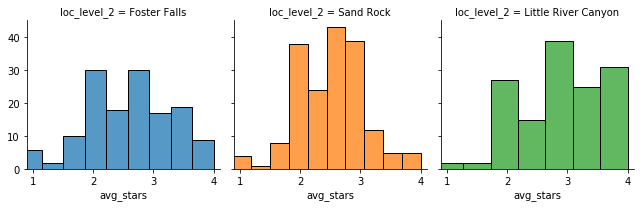

In [11]:
g = sns.FacetGrid(routes, col="loc_level_2", hue="loc_level_2", sharex=False, xlim=[0.9,4.1])
g.map(sns.histplot, "avg_stars")

#### By Wall

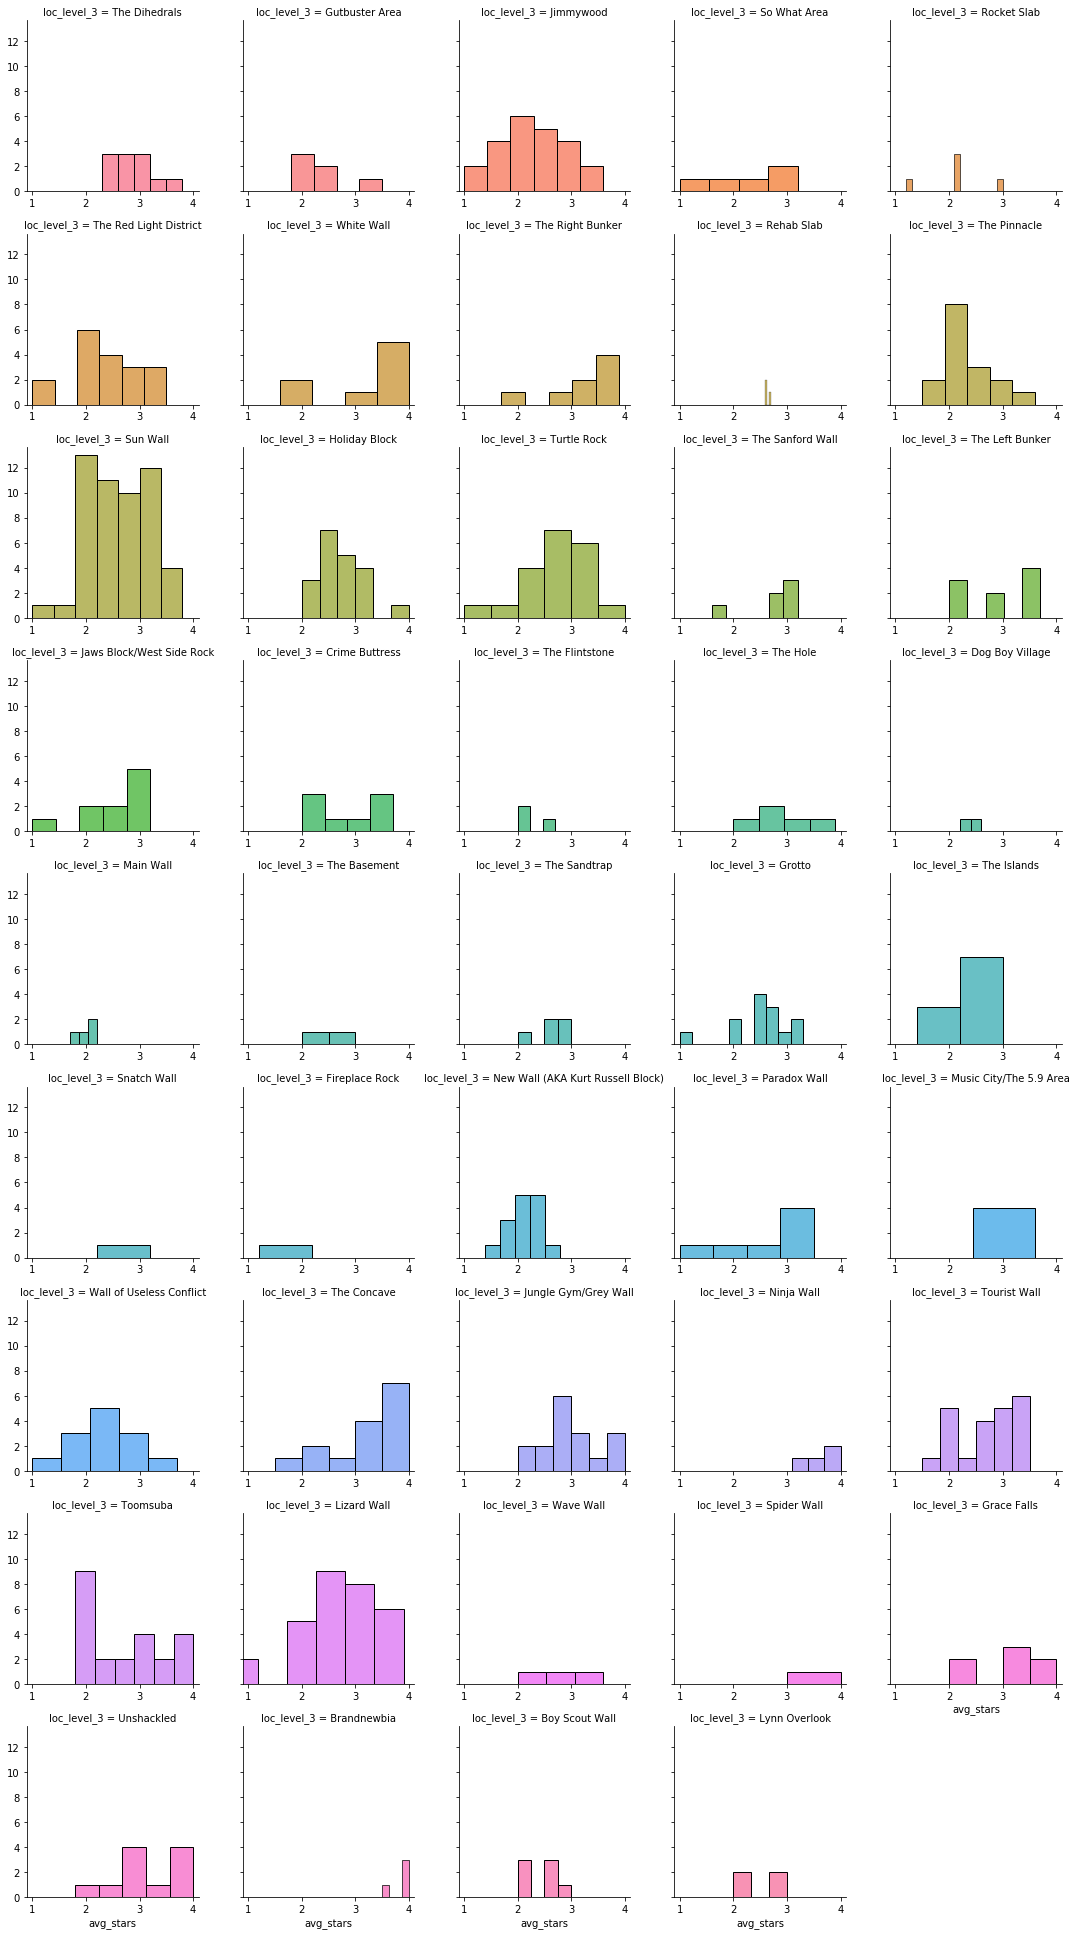

In [12]:
g = sns.FacetGrid(routes, col="loc_level_3", hue="loc_level_3", col_wrap=5, sharex=False, xlim=[0.9,4.1])
g.map(sns.histplot, "avg_stars")

### Route Traffic
(Using number of star rating votes as a proxy for popularity)

#### By Crag

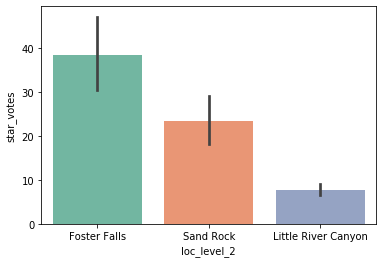

In [13]:
g = sns.barplot(data=routes, x="loc_level_2", y="star_votes", palette="Set2")

So it looks like Foster Falls is the most popular, with the average route at Foster Falls having been given a star rating by ~38 people (and that's just users of the app who take the time to leave a rating).

#### By Crag and then by Wall

In [14]:
sorted_by_votes = routes.sort_values('star_votes', ascending=False)

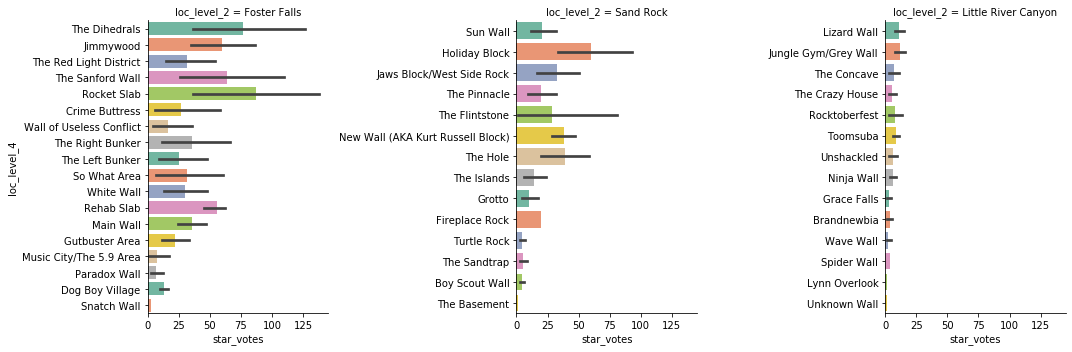

In [19]:
g = sns.FacetGrid(sorted_by_votes, col="loc_level_2", sharex=True, sharey=False, height=5, aspect=1)
g.map(sns.barplot, "star_votes", "loc_level_4", palette="Set2")

In [15]:
#To do:
# Map difficulty onto a numerical scale